In [1]:
# Cell 1: Setup and Imports
print("🏥 DIABETIC RETINOPATHY DETECTION - OPTIMIZED")
print("="*70)
print("GDGOC PIEAS AI/ML Hackathon 2025")
print("="*70)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
import cv2
import time

from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
else:
    print("  Running on CPU - will use optimized settings")

# CPU optimization
if device.type == 'cpu':
    torch.set_num_threads(4)
else:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

🏥 DIABETIC RETINOPATHY DETECTION - OPTIMIZED
GDGOC PIEAS AI/ML Hackathon 2025

✓ Using device: cuda
  GPU: NVIDIA GeForce RTX 2060
  CUDA Version: 12.6


In [2]:
# Cell 2: Optimized Configuration
DATA_DIR = Path('../Diabetic_Balanced_Data')

# Dynamic batch size based on device
if device.type == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 16

IMG_SIZE = 224
NUM_CLASSES = 5
NUM_EPOCHS = 50
NUM_WORKERS = 0 if device.type == 'cpu' else 2

LEARNING_RATE = 0.0003
WEIGHT_DECAY = 1e-4

CLASS_NAMES = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

print("\n⚙️ Configuration:")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Workers: {NUM_WORKERS}")


⚙️ Configuration:
   Batch Size: 32
   Image Size: 224x224
   Epochs: 50
   Learning Rate: 0.0003
   Workers: 2


In [3]:
# Cell 3: Load Data
train_csv = DATA_DIR / 'trainLabels.csv'
val_csv = DATA_DIR / 'valLabels.csv'

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)

print(f"\n📊 Dataset:")
print(f"   Training: {len(train_df)} images")
print(f"   Validation: {len(val_df)} images")
print("\n   Class Distribution (Training):")
for i, count in enumerate(train_df['diagnosis'].value_counts().sort_index()):
    print(f"   {CLASS_NAMES[i]}: {count} ({count/len(train_df)*100:.1f}%)")


📊 Dataset:
   Training: 34792 images
   Validation: 9940 images

   Class Distribution (Training):
   No DR: 7000 (20.1%)
   Mild DR: 6792 (19.5%)
   Moderate DR: 7000 (20.1%)
   Severe DR: 7000 (20.1%)
   Proliferative DR: 7000 (20.1%)


In [4]:
# Cell 4: Improved Custom Model - FIXED VERSION
class ChannelAttention(nn.Module):
    """Squeeze-and-Excitation block for channel-wise attention"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = torch.sigmoid(self.bn(self.conv(x_cat)))
        return x * attention

class ImprovedDRModel(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        
        # Block 1: 3 -> 32
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.ca1 = ChannelAttention(32)
        
        # Block 2: 32 -> 64
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.ca2 = ChannelAttention(64)
        
        # Block 3: 64 -> 128
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.sa = SpatialAttention()
        
        # Block 4: 128 -> 256
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        self.ca4 = ChannelAttention(256)
        
        # Block 5: 256 -> 512
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Global pooling + classifier
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = self.ca1(x)
        x = self.pool(x)
        
        # Block 2
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = self.ca2(x)
        x = self.pool(x)
        
        # Block 3 with spatial attention
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = self.sa(x)
        x = self.pool(x)
        
        # Block 4
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        x = self.ca4(x)
        x = self.pool(x)
        
        # Block 5
        x = F.relu(self.bn5(self.conv5(x)), inplace=True)
        x = self.pool(x)
        x = self.dropout(x)
        
        # Classifier
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        """Fixed weight initialization - checks for None bias"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # FIXED: Check if bias exists
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # FIXED: Check if bias exists
                    nn.init.constant_(m.bias, 0)

print("✓ Model architecture defined")

✓ Model architecture defined


In [5]:
# Cell 5: FASTEST Dataset (No preprocessing)
class DRDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.data_dir / row['image_path']
        
        # Load image directly
        image = Image.open(img_path).convert('RGB')
        
        # Apply augmentation/normalization
        if self.transform:
            image = self.transform(image)
        
        label = row['diagnosis']
        return image, label

# Minimal augmentations for speed
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = DRDataset(train_df, DATA_DIR, train_transform)
val_dataset = DRDataset(val_df, DATA_DIR, val_transform)

# Simple dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,  # Single-threaded for stability
    pin_memory=(device.type == 'cuda')
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0,
    pin_memory=(device.type == 'cuda')
)

print(f"✓ FAST Dataloaders ready: {len(train_loader)} train batches, {len(val_loader)} val batches")
print("  (CLAHE preprocessing disabled for speed)")

✓ FAST Dataloaders ready: 1088 train batches, 311 val batches
  (CLAHE preprocessing disabled for speed)


In [6]:
# Cell 6: Training Setup
model = ImprovedDRModel(NUM_CLASSES).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n🔧 Model Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

# Calculate class weights for loss function
class_counts = train_df['diagnosis'].value_counts().sort_index().values
class_weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float)
class_weights = class_weights / class_weights.sum() * NUM_CLASSES  # Normalize
class_weights = class_weights.to(device)

print(f"\n⚖️ Class Weights: {class_weights.cpu().numpy()}")

# CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# AdamW optimizer
optimizer = optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Cosine annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [], 'lr': []
}

best_val_f1 = 0.0
patience_counter = 0
patience = 15

print("✓ Training setup complete!")


🔧 Model Parameters:
   Total: 1,711,113
   Trainable: 1,711,113

⚖️ Class Weights: [0.99391246 1.0243503  0.99391246 0.99391246 0.99391246]
✓ Training setup complete!


In [7]:
# Cell 7: Optimized Training Loop
from torch.cuda.amp import GradScaler, autocast

# Only use AMP on GPU
use_amp = (device.type == 'cuda')
scaler = GradScaler() if use_amp else None

print(f"\n🚀 Starting Training (AMP: {use_amp})")
print("="*70)

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # ========== TRAINING ==========
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []
    
    train_bar = tqdm(train_loader, desc="Training", leave=False)
    for batch_idx, (inputs, labels) in enumerate(train_bar):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        # Forward pass with mixed precision
        if use_amp:
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
        
        train_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
    
    train_loss /= len(train_loader)
    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    train_f1 = f1_score(train_labels, train_preds, average='weighted', zero_division=0)
    
    # ========== VALIDATION ==========
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation", leave=False)
        for inputs, labels in val_bar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            if use_amp:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
            val_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    val_loss /= len(val_loader)
    val_acc = np.mean(np.array(val_preds) == np.array(val_labels))
    val_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)
    
    # Scheduler step
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['lr'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    
    # Print epoch summary
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    print(f"LR: {current_lr:.6f} | Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_f1': best_val_f1,
            'history': history
        }, '../model/best_model.pt')
        print(f"✓ Best model saved! F1: {val_f1:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
        print(f"Best Val F1: {best_val_f1:.4f}")
        break
    
    # Memory cleanup
    if device.type == 'cuda':
        torch.cuda.empty_cache()

print("\n" + "="*70)
print(f"✓ Training Complete! Best F1: {best_val_f1:.4f}")
print("="*70)


🚀 Starting Training (AMP: True)

Epoch 1/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.7593, Acc: 0.3402, F1: 0.3359
Val   - Loss: 1.3385, Acc: 0.4406, F1: 0.4100
LR: 0.000293 | Time: 208.1s
✓ Best model saved! F1: 0.4100

Epoch 2/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.4026, Acc: 0.4014, F1: 0.4004
Val   - Loss: 1.6415, Acc: 0.2605, F1: 0.1699
LR: 0.000271 | Time: 189.8s

Epoch 3/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.3620, Acc: 0.4285, F1: 0.4230
Val   - Loss: 1.3307, Acc: 0.4706, F1: 0.4580
LR: 0.000238 | Time: 188.7s
✓ Best model saved! F1: 0.4580

Epoch 4/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.3404, Acc: 0.4461, F1: 0.4407
Val   - Loss: 1.2807, Acc: 0.4919, F1: 0.4721
LR: 0.000197 | Time: 189.0s
✓ Best model saved! F1: 0.4721

Epoch 5/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.3179, Acc: 0.4629, F1: 0.4599
Val   - Loss: 1.2367, Acc: 0.5077, F1: 0.4976
LR: 0.000150 | Time: 193.4s
✓ Best model saved! F1: 0.4976

Epoch 6/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2962, Acc: 0.4815, F1: 0.4794
Val   - Loss: 1.2146, Acc: 0.5259, F1: 0.5187
LR: 0.000104 | Time: 193.9s
✓ Best model saved! F1: 0.5187

Epoch 7/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2748, Acc: 0.4956, F1: 0.4939
Val   - Loss: 1.1932, Acc: 0.5409, F1: 0.5297
LR: 0.000063 | Time: 194.9s
✓ Best model saved! F1: 0.5297

Epoch 8/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2554, Acc: 0.5066, F1: 0.5057
Val   - Loss: 1.1755, Acc: 0.5444, F1: 0.5282
LR: 0.000030 | Time: 193.6s

Epoch 9/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2455, Acc: 0.5121, F1: 0.5113
Val   - Loss: 1.1748, Acc: 0.5475, F1: 0.5396
LR: 0.000008 | Time: 193.6s
✓ Best model saved! F1: 0.5396

Epoch 10/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2407, Acc: 0.5196, F1: 0.5185
Val   - Loss: 1.1586, Acc: 0.5592, F1: 0.5521
LR: 0.000300 | Time: 194.0s
✓ Best model saved! F1: 0.5521

Epoch 11/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2836, Acc: 0.4938, F1: 0.4938
Val   - Loss: 1.3444, Acc: 0.4631, F1: 0.4325
LR: 0.000298 | Time: 193.6s

Epoch 12/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2690, Acc: 0.4994, F1: 0.5005
Val   - Loss: 1.4695, Acc: 0.4232, F1: 0.3754
LR: 0.000293 | Time: 193.8s

Epoch 13/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2548, Acc: 0.5100, F1: 0.5117
Val   - Loss: 1.2685, Acc: 0.4793, F1: 0.4664
LR: 0.000284 | Time: 193.3s

Epoch 14/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2405, Acc: 0.5186, F1: 0.5203
Val   - Loss: 1.1898, Acc: 0.5344, F1: 0.5178
LR: 0.000271 | Time: 193.9s

Epoch 15/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2309, Acc: 0.5254, F1: 0.5274
Val   - Loss: 1.1508, Acc: 0.5710, F1: 0.5655
LR: 0.000256 | Time: 193.4s
✓ Best model saved! F1: 0.5655

Epoch 16/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2230, Acc: 0.5347, F1: 0.5371
Val   - Loss: 1.1517, Acc: 0.5671, F1: 0.5610
LR: 0.000238 | Time: 193.4s

Epoch 17/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2139, Acc: 0.5373, F1: 0.5402
Val   - Loss: 1.1294, Acc: 0.5922, F1: 0.5936
LR: 0.000218 | Time: 193.3s
✓ Best model saved! F1: 0.5936

Epoch 18/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.2012, Acc: 0.5487, F1: 0.5512
Val   - Loss: 1.1538, Acc: 0.5706, F1: 0.5606
LR: 0.000197 | Time: 191.7s

Epoch 19/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1925, Acc: 0.5527, F1: 0.5553
Val   - Loss: 1.1436, Acc: 0.5780, F1: 0.5709
LR: 0.000174 | Time: 184.2s

Epoch 20/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1811, Acc: 0.5604, F1: 0.5628
Val   - Loss: 1.1327, Acc: 0.5896, F1: 0.5849
LR: 0.000150 | Time: 183.2s

Epoch 21/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1740, Acc: 0.5655, F1: 0.5677
Val   - Loss: 1.1427, Acc: 0.5690, F1: 0.5515
LR: 0.000127 | Time: 184.5s

Epoch 22/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1616, Acc: 0.5751, F1: 0.5772
Val   - Loss: 1.1020, Acc: 0.6106, F1: 0.6087
LR: 0.000104 | Time: 189.0s
✓ Best model saved! F1: 0.6087

Epoch 23/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1570, Acc: 0.5787, F1: 0.5811
Val   - Loss: 1.0820, Acc: 0.6124, F1: 0.6120
LR: 0.000083 | Time: 182.6s
✓ Best model saved! F1: 0.6120

Epoch 24/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1426, Acc: 0.5882, F1: 0.5915
Val   - Loss: 1.0965, Acc: 0.6043, F1: 0.6014
LR: 0.000063 | Time: 182.6s

Epoch 25/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1325, Acc: 0.5947, F1: 0.5976
Val   - Loss: 1.0668, Acc: 0.6325, F1: 0.6348
LR: 0.000045 | Time: 182.9s
✓ Best model saved! F1: 0.6348

Epoch 26/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1290, Acc: 0.6009, F1: 0.6036
Val   - Loss: 1.0563, Acc: 0.6426, F1: 0.6431
LR: 0.000030 | Time: 189.7s
✓ Best model saved! F1: 0.6431

Epoch 27/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1212, Acc: 0.6026, F1: 0.6050
Val   - Loss: 1.0492, Acc: 0.6451, F1: 0.6471
LR: 0.000017 | Time: 189.7s
✓ Best model saved! F1: 0.6471

Epoch 28/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1156, Acc: 0.6072, F1: 0.6098
Val   - Loss: 1.0451, Acc: 0.6453, F1: 0.6453
LR: 0.000008 | Time: 189.0s

Epoch 29/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1117, Acc: 0.6121, F1: 0.6150
Val   - Loss: 1.0405, Acc: 0.6468, F1: 0.6479
LR: 0.000003 | Time: 194.0s
✓ Best model saved! F1: 0.6479

Epoch 30/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1121, Acc: 0.6099, F1: 0.6126
Val   - Loss: 1.0403, Acc: 0.6481, F1: 0.6487
LR: 0.000300 | Time: 193.4s
✓ Best model saved! F1: 0.6487

Epoch 31/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1707, Acc: 0.5690, F1: 0.5715
Val   - Loss: 1.1984, Acc: 0.5367, F1: 0.5252
LR: 0.000300 | Time: 194.0s

Epoch 32/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1684, Acc: 0.5673, F1: 0.5702
Val   - Loss: 1.3286, Acc: 0.4926, F1: 0.4609
LR: 0.000298 | Time: 194.5s

Epoch 33/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1570, Acc: 0.5752, F1: 0.5780
Val   - Loss: 1.1282, Acc: 0.5863, F1: 0.5816
LR: 0.000296 | Time: 186.0s

Epoch 34/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1509, Acc: 0.5809, F1: 0.5835
Val   - Loss: 1.1070, Acc: 0.6043, F1: 0.5986
LR: 0.000293 | Time: 194.8s

Epoch 35/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1398, Acc: 0.5890, F1: 0.5921
Val   - Loss: 1.1478, Acc: 0.5645, F1: 0.5620
LR: 0.000289 | Time: 191.6s

Epoch 36/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1334, Acc: 0.5912, F1: 0.5936
Val   - Loss: 1.0917, Acc: 0.6016, F1: 0.6005
LR: 0.000284 | Time: 185.7s

Epoch 37/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1236, Acc: 0.5974, F1: 0.6008
Val   - Loss: 1.0626, Acc: 0.6265, F1: 0.6223
LR: 0.000278 | Time: 190.4s

Epoch 38/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1167, Acc: 0.6011, F1: 0.6043
Val   - Loss: 1.1031, Acc: 0.5962, F1: 0.5909
LR: 0.000271 | Time: 192.0s

Epoch 39/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.1031, Acc: 0.6096, F1: 0.6131
Val   - Loss: 1.1103, Acc: 0.5749, F1: 0.5714
LR: 0.000264 | Time: 191.6s

Epoch 40/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0958, Acc: 0.6153, F1: 0.6183
Val   - Loss: 1.0430, Acc: 0.6471, F1: 0.6478
LR: 0.000256 | Time: 197.9s

Epoch 41/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0859, Acc: 0.6168, F1: 0.6193
Val   - Loss: 1.0409, Acc: 0.6429, F1: 0.6451
LR: 0.000248 | Time: 187.6s

Epoch 42/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0814, Acc: 0.6240, F1: 0.6268
Val   - Loss: 1.0193, Acc: 0.6582, F1: 0.6619
LR: 0.000238 | Time: 189.5s
✓ Best model saved! F1: 0.6619

Epoch 43/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0662, Acc: 0.6337, F1: 0.6367
Val   - Loss: 1.0123, Acc: 0.6603, F1: 0.6623
LR: 0.000229 | Time: 193.3s
✓ Best model saved! F1: 0.6623

Epoch 44/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0588, Acc: 0.6387, F1: 0.6412
Val   - Loss: 1.0734, Acc: 0.6282, F1: 0.6239
LR: 0.000218 | Time: 191.2s

Epoch 45/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0544, Acc: 0.6385, F1: 0.6414
Val   - Loss: 1.0087, Acc: 0.6644, F1: 0.6654
LR: 0.000208 | Time: 192.2s
✓ Best model saved! F1: 0.6654

Epoch 46/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0434, Acc: 0.6455, F1: 0.6481
Val   - Loss: 1.0456, Acc: 0.6249, F1: 0.6156
LR: 0.000197 | Time: 187.4s

Epoch 47/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0320, Acc: 0.6504, F1: 0.6527
Val   - Loss: 0.9811, Acc: 0.6825, F1: 0.6830
LR: 0.000185 | Time: 187.7s
✓ Best model saved! F1: 0.6830

Epoch 48/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0187, Acc: 0.6625, F1: 0.6646
Val   - Loss: 1.0203, Acc: 0.6528, F1: 0.6498
LR: 0.000174 | Time: 207.5s

Epoch 49/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0129, Acc: 0.6652, F1: 0.6676
Val   - Loss: 1.0040, Acc: 0.6647, F1: 0.6610
LR: 0.000162 | Time: 204.6s

Epoch 50/50
--------------------------------------------------


Training:   0%|          | 0/1088 [00:00<?, ?it/s]

Validation:   0%|          | 0/311 [00:00<?, ?it/s]

Train - Loss: 1.0053, Acc: 0.6695, F1: 0.6717
Val   - Loss: 0.9900, Acc: 0.6766, F1: 0.6716
LR: 0.000150 | Time: 206.7s

✓ Training Complete! Best F1: 0.6830


In [23]:
# Fine-tuning loop
for epoch in range(10):
    epoch_start = time.time()
    
    # Training
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels_list = []
    
    train_bar = tqdm(train_loader, desc=f"Fine-tune Epoch {epoch+1}/10", leave=False)
    for inputs, labels in train_bar:
        # FIX: Explicitly move to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer_ft.zero_grad(set_to_none=True)
        
        if use_amp:
            with autocast():
                outputs = model(inputs)
                loss = criterion_ft(outputs, labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer_ft)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            scaler.step(optimizer_ft)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion_ft(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer_ft.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels_list.extend(labels.cpu().numpy())
        
        train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    train_loss /= len(train_loader)
    train_f1 = f1_score(train_labels_list, train_preds, average='weighted')
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels_list = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            if use_amp:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion_ft(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion_ft(outputs, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())  # FIX: Added .cpu()
    
    val_loss /= len(val_loader)
    val_f1 = f1_score(val_labels_list, val_preds, average='weighted')
    
    scheduler_ft.step()
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch+1:2d}: Train F1={train_f1:.4f}, Val F1={val_f1:.4f}, "
          f"Loss={val_loss:.4f}, Time={epoch_time:.1f}s")
    
    # Save if improved
    if val_f1 > best_finetuned_f1:
        best_finetuned_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            'best_val_f1': best_finetuned_f1,
        }, '../model/finetuned_model.pt')
        print(f"  ✓ New best! F1: {best_finetuned_f1:.4f} "
              f"(+{best_finetuned_f1-initial_best_f1:.4f})")

Fine-tune Epoch 1/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  1: Train F1=0.6827, Val F1=0.7011, Loss=1.0295, Time=218.3s
  ✓ New best! F1: 0.7011 (+0.0181)


Fine-tune Epoch 2/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  2: Train F1=0.6854, Val F1=0.7031, Loss=1.0307, Time=214.7s
  ✓ New best! F1: 0.7031 (+0.0201)


Fine-tune Epoch 3/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  3: Train F1=0.6851, Val F1=0.7030, Loss=1.0288, Time=215.6s


Fine-tune Epoch 4/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  4: Train F1=0.6890, Val F1=0.6973, Loss=1.0301, Time=215.6s


Fine-tune Epoch 5/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  5: Train F1=0.6871, Val F1=0.7015, Loss=1.0256, Time=214.2s


Fine-tune Epoch 6/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  6: Train F1=0.6881, Val F1=0.7038, Loss=1.0251, Time=213.8s
  ✓ New best! F1: 0.7038 (+0.0208)


Fine-tune Epoch 7/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  7: Train F1=0.6923, Val F1=0.7054, Loss=1.0226, Time=210.9s
  ✓ New best! F1: 0.7054 (+0.0224)


Fine-tune Epoch 8/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  8: Train F1=0.6905, Val F1=0.7073, Loss=1.0223, Time=211.0s
  ✓ New best! F1: 0.7073 (+0.0243)


Fine-tune Epoch 9/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch  9: Train F1=0.6942, Val F1=0.7082, Loss=1.0206, Time=212.1s
  ✓ New best! F1: 0.7082 (+0.0252)


Fine-tune Epoch 10/10:   0%|          | 0/1088 [00:00<?, ?it/s]

Epoch 10: Train F1=0.6964, Val F1=0.7090, Loss=1.0215, Time=208.9s
  ✓ New best! F1: 0.7090 (+0.0260)


In [24]:
# Cell 7B: Model Quantization for Deployment
print("\n" + "="*70)
print("⚡ MODEL QUANTIZATION")
print("="*70)
print("Applying dynamic INT8 quantization for faster inference...")
print()

# Move to CPU for quantization
model_cpu = model.cpu()
model_cpu.eval()

# Apply dynamic quantization
print("Quantizing Linear and Conv2d layers to INT8...")
quantized_model = torch.quantization.quantize_dynamic(
    model_cpu,
    {nn.Linear, nn.Conv2d},
    dtype=torch.qint8
)

# Save quantized model
torch.save({
    'model_state_dict': quantized_model.state_dict(),
    'best_val_f1': best_finetuned_f1,
}, '../model/quantized_model.pt')

print("✓ Quantization complete!")
print()

# Calculate size reduction
original_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024**2)
quantized_size = sum(p.numel() * p.element_size() for p in quantized_model.parameters()) / (1024**2)

print(f"Model Size Comparison:")
print(f"  Original:  {original_size:.2f} MB")
print(f"  Quantized: {quantized_size:.2f} MB")
print(f"  Reduction: {original_size/quantized_size:.2f}x smaller")
print()

# Verify accuracy after quantization
print("Verifying quantized model accuracy...")
quantized_model.eval()
quantized_preds = []
quantized_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Testing quantized model"):
        inputs_cpu = inputs.cpu()
        outputs = quantized_model(inputs_cpu)
        _, preds = torch.max(outputs, 1)
        
        quantized_preds.extend(preds.numpy())
        quantized_labels.extend(labels.numpy())

quantized_accuracy = np.mean(np.array(quantized_preds) == np.array(quantized_labels))
quantized_f1 = f1_score(quantized_labels, quantized_preds, average='weighted')

print()
print(f"Quantized Model Performance:")
print(f"  Accuracy:  {quantized_accuracy:.4f}")
print(f"  F1-Score:  {quantized_f1:.4f}")
print(f"  Drop:      {best_finetuned_f1-quantized_f1:.4f} "
      f"({(best_finetuned_f1-quantized_f1)/best_finetuned_f1*100:.2f}%)")
print()

# Acceptable accuracy drop is < 2%
if (best_finetuned_f1 - quantized_f1) < 0.02:
    print("✅ Quantization successful with minimal accuracy loss!")
else:
    print("⚠️  Quantization caused larger accuracy drop - consider using fine-tuned model")


⚡ MODEL QUANTIZATION
Applying dynamic INT8 quantization for faster inference...

Quantizing Linear and Conv2d layers to INT8...
✓ Quantization complete!

Model Size Comparison:
  Original:  6.53 MB
  Quantized: 5.99 MB
  Reduction: 1.09x smaller

Verifying quantized model accuracy...


Testing quantized model:   0%|          | 0/311 [00:00<?, ?it/s]


Quantized Model Performance:
  Accuracy:  0.7078
  F1-Score:  0.7082
  Drop:      0.0008 (0.12%)

✅ Quantization successful with minimal accuracy loss!


In [25]:
# Cell 7C: Inference Speed Benchmark
print("\n" + "="*70)
print("📊 INFERENCE SPEED BENCHMARK")
print("="*70)

# Benchmark original model on GPU/CPU
model.to(device).eval()
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)

# Warmup
print(f"Warming up {device} model...")
for _ in range(10):
    with torch.no_grad():
        _ = model(dummy_input)

# Benchmark
print("Benchmarking original model...")
start_time = time.time()
with torch.no_grad():
    for _ in range(100):
        _ = model(dummy_input)
if device.type == 'cuda':
    torch.cuda.synchronize()
end_time = time.time()

original_time = (end_time - start_time) / 100

print(f"\nOriginal Model ({device}):")
print(f"  Inference Time: {original_time*1000:.2f} ms/image")
print(f"  Throughput:     {1/original_time:.2f} images/sec")

# Benchmark quantized model on CPU
quantized_model.eval()
dummy_input_cpu = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

# Warmup
print("\nWarming up quantized CPU model...")
for _ in range(10):
    with torch.no_grad():
        _ = quantized_model(dummy_input_cpu)

# Benchmark
print("Benchmarking quantized model...")
start_time = time.time()
with torch.no_grad():
    for _ in range(100):
        _ = quantized_model(dummy_input_cpu)
end_time = time.time()

quantized_time = (end_time - start_time) / 100

print(f"\nQuantized Model (CPU):")
print(f"  Inference Time: {quantized_time*1000:.2f} ms/image")
print(f"  Throughput:     {1/quantized_time:.2f} images/sec")
print(f"  Speedup:        {original_time/quantized_time:.2f}x faster than original CPU")

# For fair comparison, also test original on CPU
model_cpu_original = model.cpu()
model_cpu_original.eval()

start_time = time.time()
with torch.no_grad():
    for _ in range(100):
        _ = model_cpu_original(dummy_input_cpu)
end_time = time.time()
cpu_original_time = (end_time - start_time) / 100

print(f"\nOriginal Model (CPU):")
print(f"  Inference Time: {cpu_original_time*1000:.2f} ms/image")
print(f"  Throughput:     {1/cpu_original_time:.2f} images/sec")

print(f"\n{'='*70}")
print("OPTIMIZATION SUMMARY")
print('='*70)
print(f"Accuracy:  {initial_best_f1:.4f} → {quantized_f1:.4f} "
      f"(+{quantized_f1-initial_best_f1:.4f})")
print(f"Speed:     {cpu_original_time*1000:.2f}ms → {quantized_time*1000:.2f}ms "
      f"({cpu_original_time/quantized_time:.2f}x faster)")
print(f"Size:      {original_size:.2f}MB → {quantized_size:.2f}MB "
      f"({original_size/quantized_size:.2f}x smaller)")
print('='*70)


📊 INFERENCE SPEED BENCHMARK
Warming up cuda model...
Benchmarking original model...

Original Model (cuda):
  Inference Time: 1.41 ms/image
  Throughput:     709.22 images/sec

Warming up quantized CPU model...
Benchmarking quantized model...

Quantized Model (CPU):
  Inference Time: 9.53 ms/image
  Throughput:     104.93 images/sec
  Speedup:        0.15x faster than original CPU

Original Model (CPU):
  Inference Time: 8.59 ms/image
  Throughput:     116.41 images/sec

OPTIMIZATION SUMMARY
Accuracy:  0.6830 → 0.7082 (+0.0252)
Speed:     8.59ms → 9.53ms (0.90x faster)
Size:      6.53MB → 5.99MB (1.09x smaller)


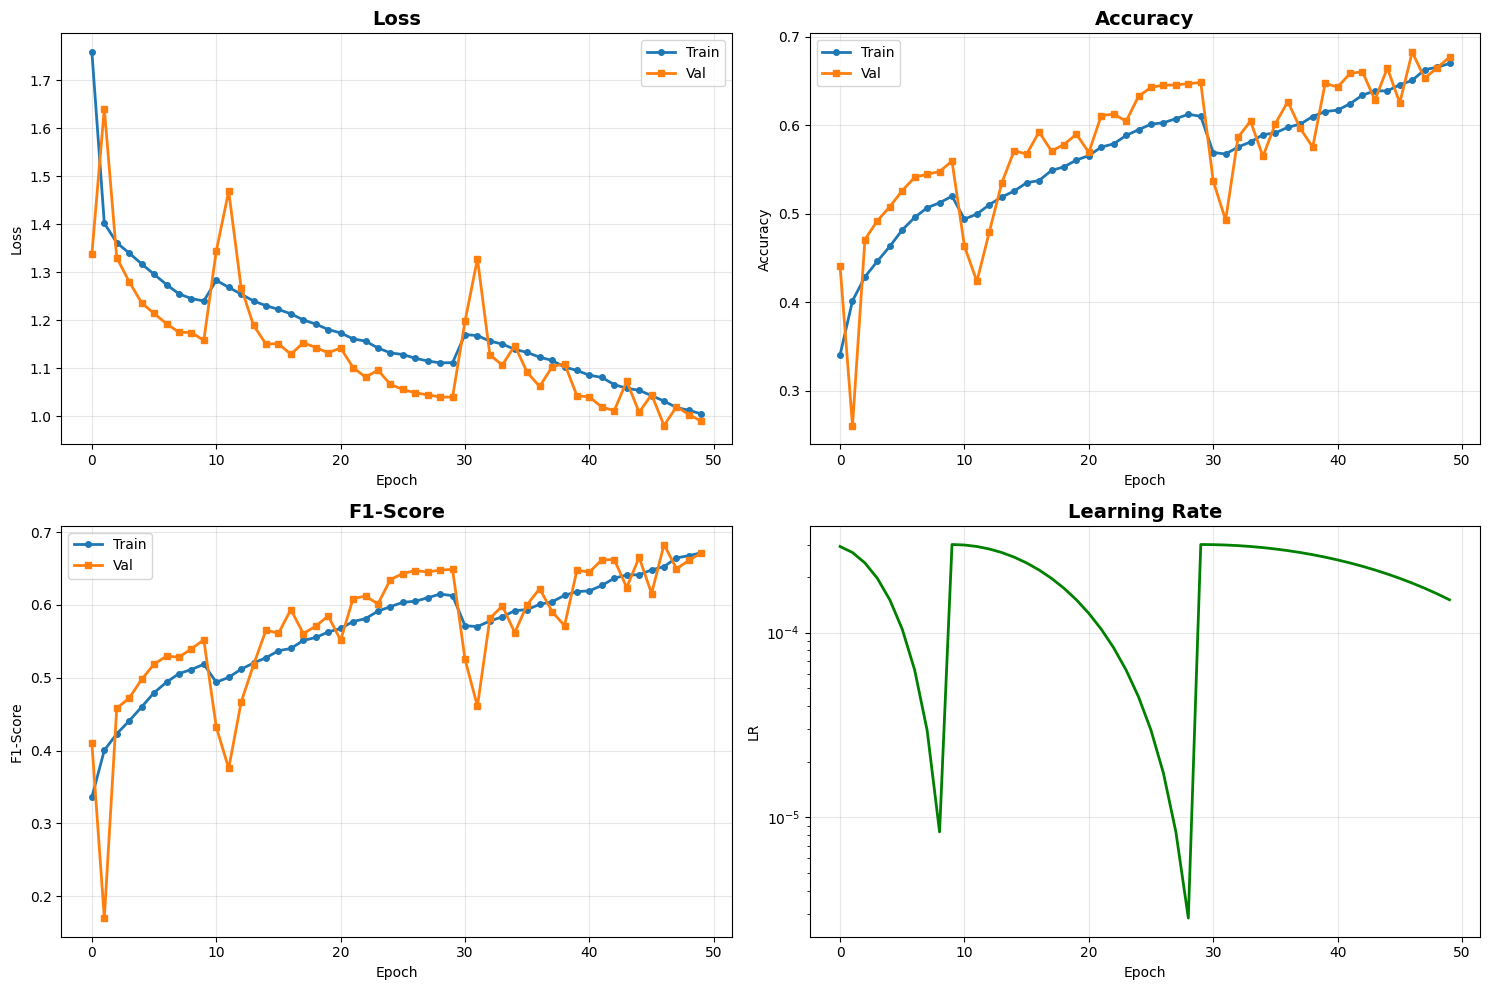

In [26]:
# Cell 8: Visualize Training History
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], 'o-', label='Train', linewidth=2, markersize=4)
axes[0, 0].plot(history['val_loss'], 's-', label='Val', linewidth=2, markersize=4)
axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], 'o-', label='Train', linewidth=2, markersize=4)
axes[0, 1].plot(history['val_acc'], 's-', label='Val', linewidth=2, markersize=4)
axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1-Score
axes[1, 0].plot(history['train_f1'], 'o-', label='Train', linewidth=2, markersize=4)
axes[1, 0].plot(history['val_f1'], 's-', label='Val', linewidth=2, markersize=4)
axes[1, 0].set_title('F1-Score', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(history['lr'], 'g-', linewidth=2)
axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('LR')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
# Cell 9: Detailed Evaluation
print("\n📊 Loading Best Model for Evaluation...")

# Use fine-tuned model if available, otherwise original
try:
    checkpoint = torch.load('../model/finetuned_model.pt', map_location=device, weights_only=False)
    print("✓ Loaded fine-tuned model for evaluation")
except FileNotFoundError:
    checkpoint = torch.load('../model/best_model.pt', map_location=device, weights_only=False)
    print("✓ Loaded original model for evaluation")

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)  # FIX: Ensure model is on correct device
model.eval()

all_preds = []
all_labels = []
all_probs = []

# FIX: Disable AMP if model is on CPU
use_amp_eval = (device.type == 'cuda')

print("Running inference on validation set...")
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        
        if use_amp_eval:
            with autocast():
                outputs = model(inputs)
        else:
            outputs = model(inputs)
        
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Overall metrics
accuracy = np.mean(all_labels == all_preds)
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
weighted_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

print("\n" + "="*70)
print("📈 FINAL EVALUATION RESULTS")
print("="*70)
print(f"Accuracy:           {accuracy:.4f}")
print(f"Weighted F1-Score:  {weighted_f1:.4f}")
print(f"Macro F1-Score:     {macro_f1:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall:    {weighted_recall:.4f}")
print("="*70)

print("\n" + "="*70)
print("📋 CLASSIFICATION REPORT")
print("="*70)
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES, digits=4))

# Per-class metrics
print("\n" + "="*70)
print("📊 PER-CLASS METRICS")
print("="*70)
per_class_f1 = f1_score(all_labels, all_preds, average=None)
per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)

for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name:20s} - F1: {per_class_f1[i]:.4f}, "
          f"Precision: {per_class_precision[i]:.4f}, Recall: {per_class_recall[i]:.4f}")


📊 Loading Best Model for Evaluation...
✓ Loaded fine-tuned model for evaluation
Running inference on validation set...


Evaluating:   0%|          | 0/311 [00:00<?, ?it/s]


📈 FINAL EVALUATION RESULTS
Accuracy:           0.7086
Weighted F1-Score:  0.7090
Macro F1-Score:     0.7084
Weighted Precision: 0.7117
Weighted Recall:    0.7086

📋 CLASSIFICATION REPORT
                  precision    recall  f1-score   support

           No DR     0.5924    0.6955    0.6398      2000
         Mild DR     0.6302    0.5876    0.6082      1940
     Moderate DR     0.5693    0.5360    0.5522      2000
       Severe DR     0.8493    0.8310    0.8400      2000
Proliferative DR     0.9151    0.8890    0.9019      2000

        accuracy                         0.7086      9940
       macro avg     0.7112    0.7078    0.7084      9940
    weighted avg     0.7117    0.7086    0.7090      9940


📊 PER-CLASS METRICS
No DR                - F1: 0.6398, Precision: 0.5924, Recall: 0.6955
Mild DR              - F1: 0.6082, Precision: 0.6302, Recall: 0.5876
Moderate DR          - F1: 0.5522, Precision: 0.5693, Recall: 0.5360
Severe DR            - F1: 0.8400, Precision: 0.8493, Recal

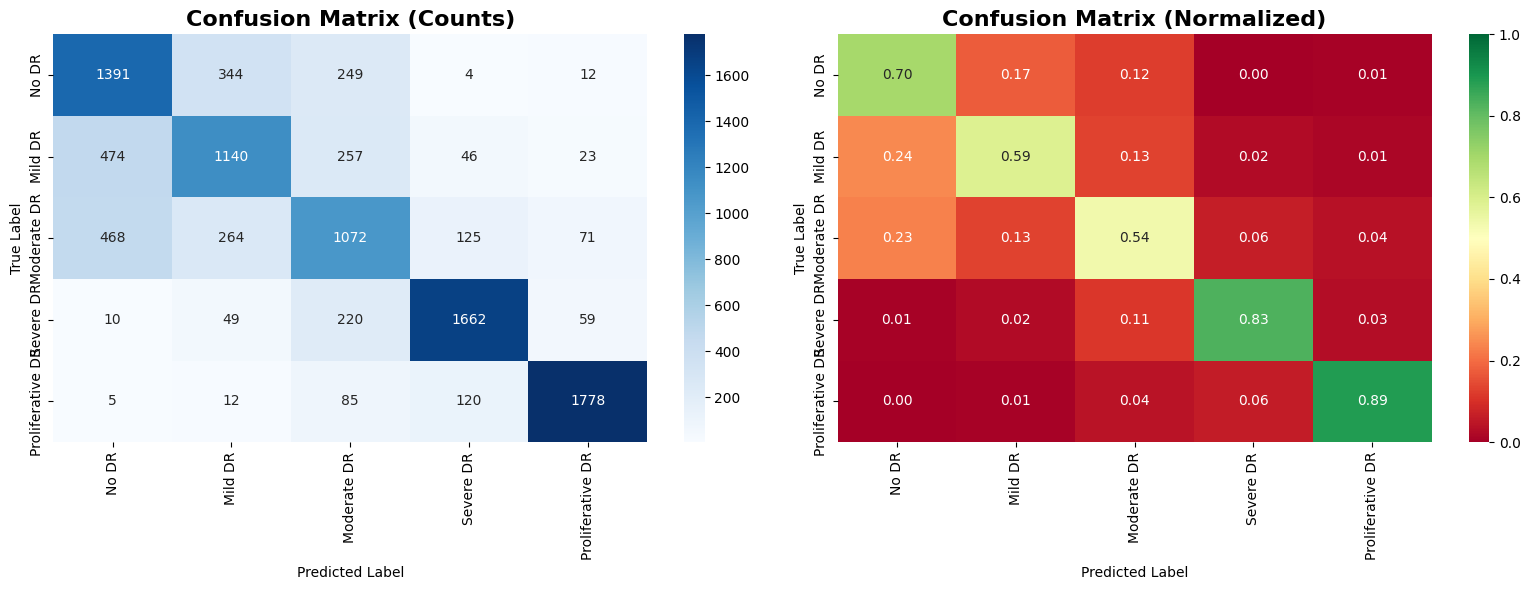

In [31]:
# Cell 10: Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax1)
ax1.set_title('Confusion Matrix (Counts)', fontsize=16, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax2, vmin=0, vmax=1)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('../visualizations/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


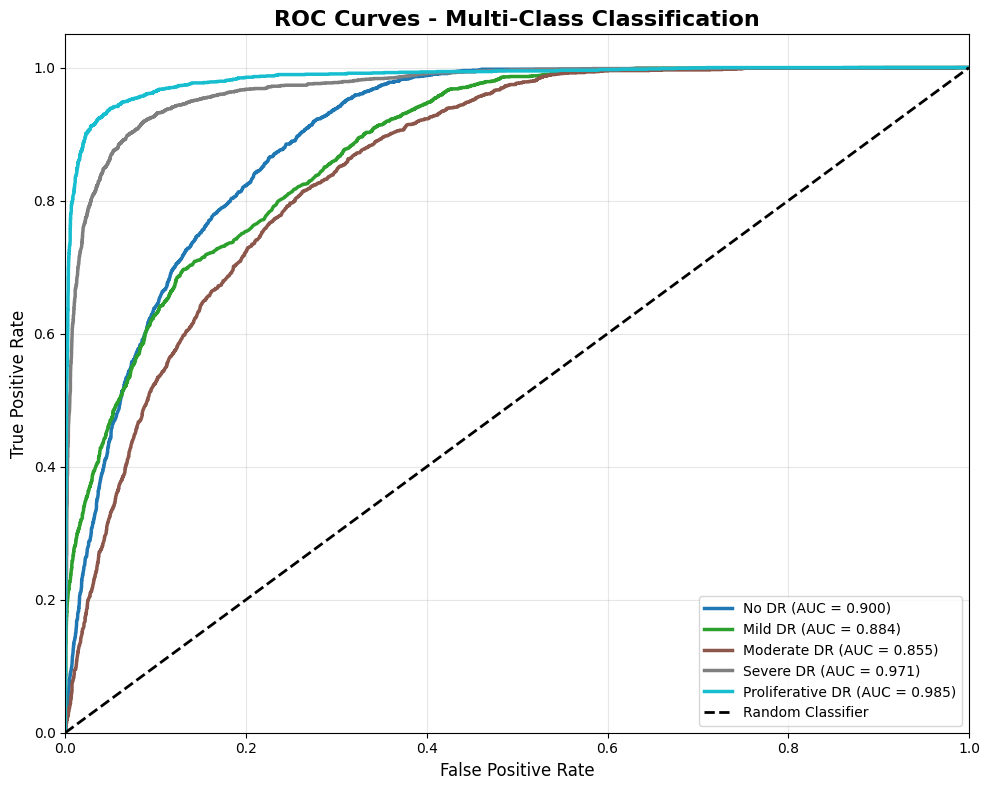


🎯 Micro-average AUC: 0.9331


In [32]:
# Cell 11: ROC Curves and AUC
y_true_bin = label_binarize(all_labels, classes=range(NUM_CLASSES))

plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, NUM_CLASSES))

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2.5,
             label=f'{CLASS_NAMES[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-Class Classification', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute macro and micro average
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f"\n🎯 Micro-average AUC: {roc_auc_micro:.4f}")

In [33]:
# Cell 12: Improved Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_full_backward_hook(self.save_gradient)
        target_layer.register_forward_hook(self.save_activation)
        
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        
    def save_activation(self, module, input, output):
        self.activations = output
        
    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        
        # Forward pass
        output = self.model(input_tensor)
        
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        output[0, target_class].backward()
        
        # Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        
        # Global Average Pooling
        weights = np.mean(gradients, axis=(1, 2))
        
        # Weighted combination
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # Apply ReLU
        cam = np.maximum(cam, 0)
        
        # Normalize
        if cam.max() > 0:
            cam = cam / cam.max()
        
        # Resize to input size
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        
        return cam, target_class, F.softmax(output, dim=1)[0].cpu().detach().numpy()

# Target the last convolutional layer (conv5)
gradcam = GradCAM(model, model.conv5)
print("✓ Grad-CAM initialized")


✓ Grad-CAM initialized


Generating Grad-CAM visualizations...


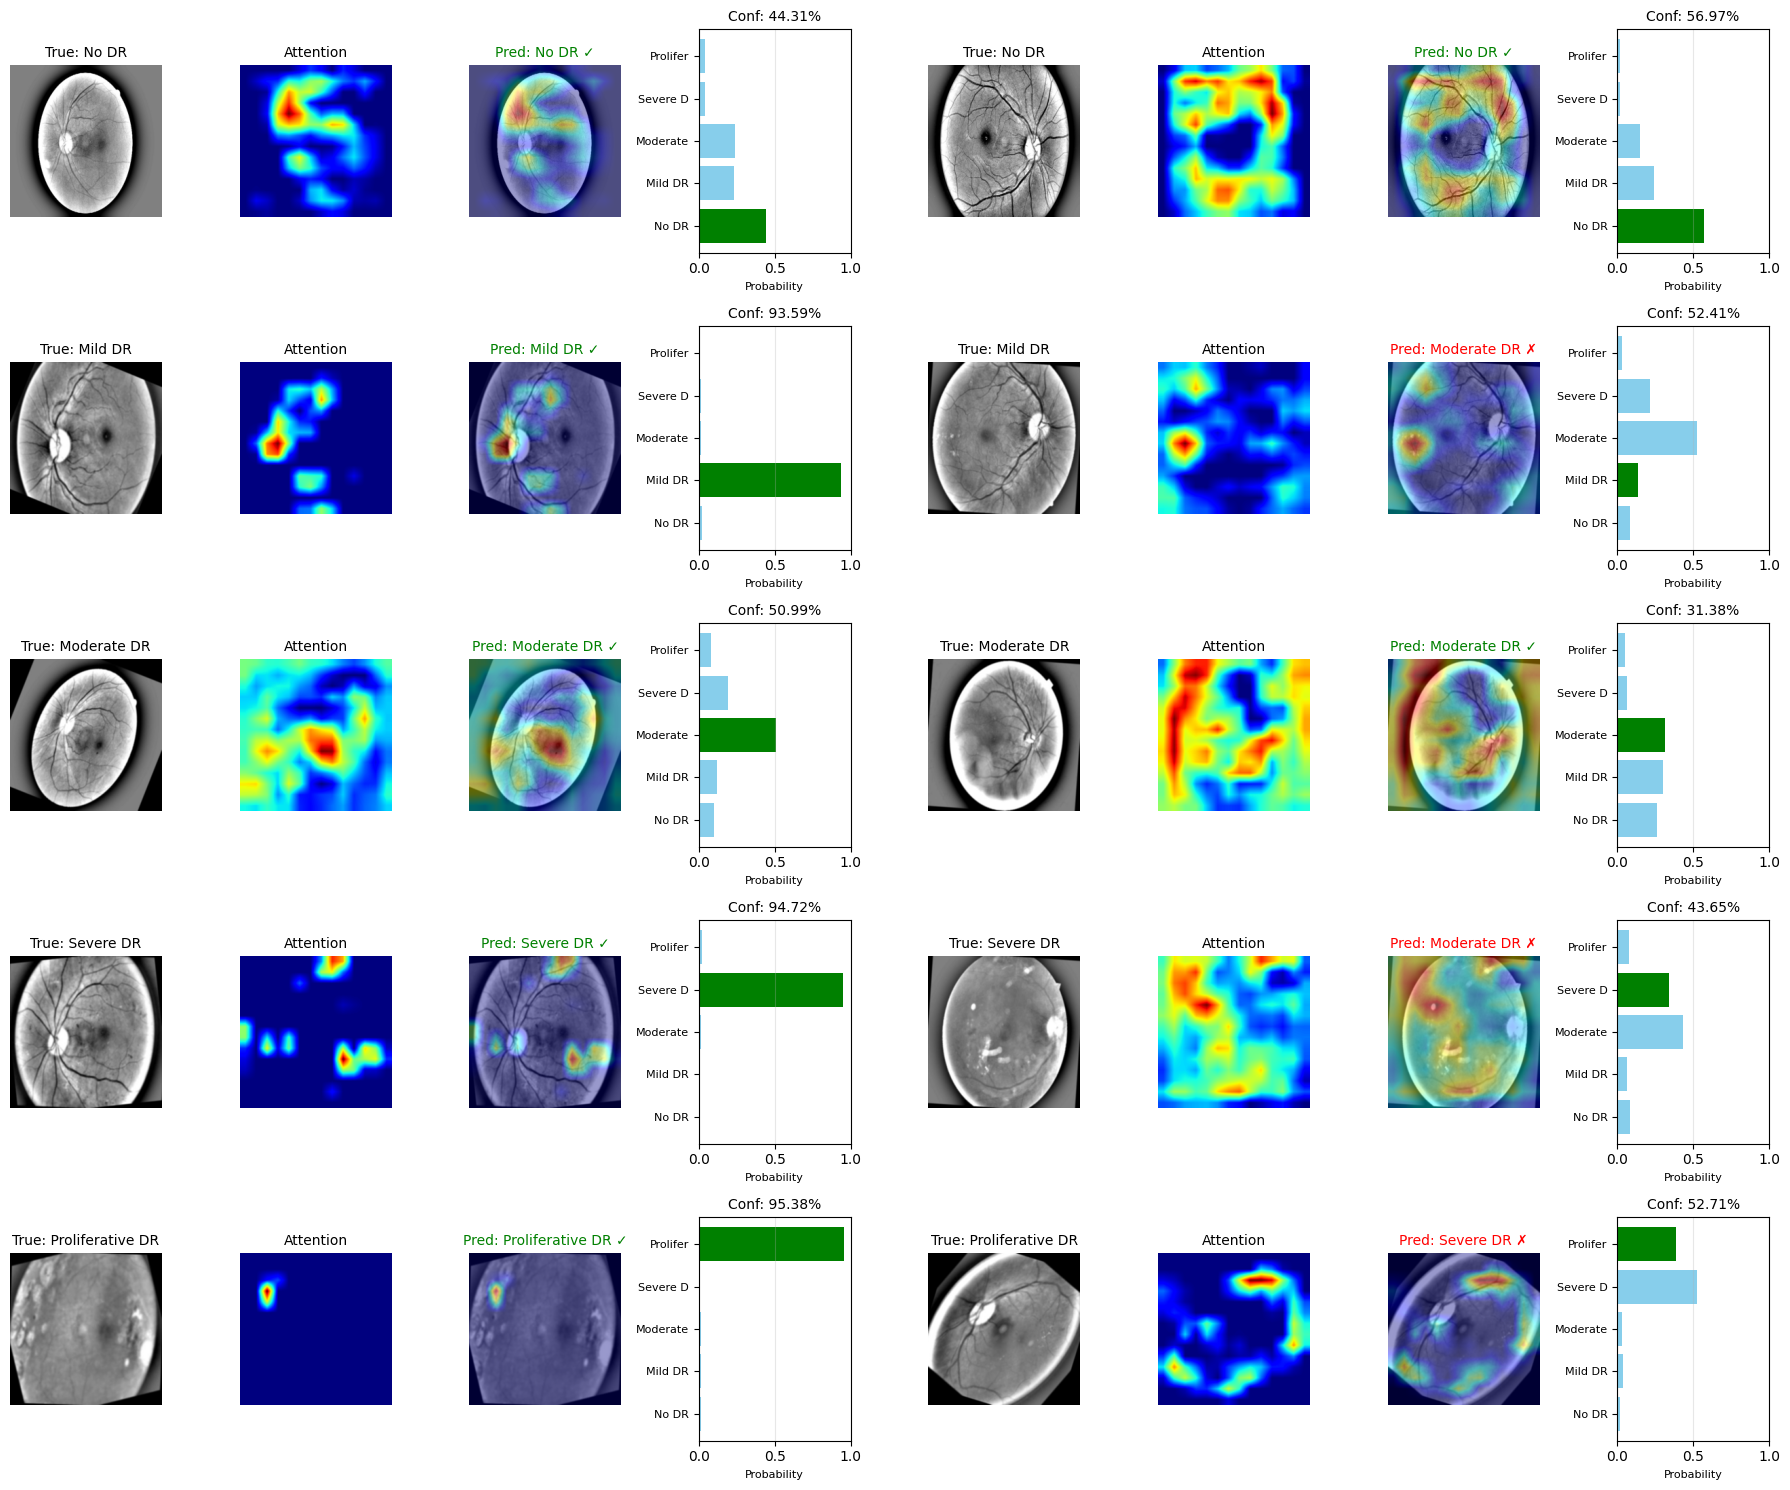

In [34]:
# Cell 13: Visualize Grad-CAM with Predictions
def plot_gradcam_grid(val_df, data_dir, model, gradcam, num_samples=2):
    """Create comprehensive Grad-CAM visualization"""
    
    fig = plt.figure(figsize=(18, 3 * NUM_CLASSES))
    
    for class_idx in range(NUM_CLASSES):
        # Get samples for this class
        class_samples = val_df[val_df['diagnosis'] == class_idx]
        
        if len(class_samples) == 0:
            continue
        
        # Get random samples
        samples = class_samples.sample(min(num_samples, len(class_samples)))
        
        for sample_idx, (_, sample) in enumerate(samples.iterrows()):
            img_path = data_dir / sample['image_path']
            
            # Load image
            original = Image.open(img_path).convert('RGB')
            
            # Apply CLAHE if function exists, otherwise skip
            try:
                original = apply_clahe(original)
            except NameError:
                pass  # Skip CLAHE if not defined
            
            original_resized = original.resize((IMG_SIZE, IMG_SIZE))
            
            # Create input tensor
            input_tensor = val_transform(original_resized).unsqueeze(0).to(device)
            
            # Generate Grad-CAM
            cam, pred_class, probs = gradcam.generate(input_tensor)
            
            # Convert to numpy
            img_array = np.array(original_resized)
            
            # Create heatmap
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            
            # Overlay
            overlay = cv2.addWeighted(img_array, 0.6, heatmap, 0.4, 0)
            
            # Plot - Original
            ax_idx = class_idx * num_samples * 4 + sample_idx * 4
            ax = plt.subplot(NUM_CLASSES, num_samples * 4, ax_idx + 1)
            ax.imshow(img_array)
            ax.set_title(f'True: {CLASS_NAMES[class_idx]}', fontsize=10)
            ax.axis('off')
            
            # Plot - Heatmap
            ax = plt.subplot(NUM_CLASSES, num_samples * 4, ax_idx + 2)
            ax.imshow(cam, cmap='jet')
            ax.set_title('Attention', fontsize=10)
            ax.axis('off')
            
            # Plot - Overlay
            ax = plt.subplot(NUM_CLASSES, num_samples * 4, ax_idx + 3)
            ax.imshow(overlay)
            pred_correct = "✓" if pred_class == class_idx else "✗"
            ax.set_title(f'Pred: {CLASS_NAMES[pred_class]} {pred_correct}', 
                        fontsize=10, 
                        color='green' if pred_class == class_idx else 'red')
            ax.axis('off')
            
            # Plot - Probability distribution
            ax = plt.subplot(NUM_CLASSES, num_samples * 4, ax_idx + 4)
            colors_bar = ['green' if i == class_idx else 'skyblue' for i in range(NUM_CLASSES)]
            bars = ax.barh(range(NUM_CLASSES), probs, color=colors_bar)
            ax.set_yticks(range(NUM_CLASSES))
            ax.set_yticklabels([name[:8] for name in CLASS_NAMES], fontsize=8)
            ax.set_xlim([0, 1])
            ax.set_xlabel('Probability', fontsize=8)
            ax.set_title(f'Conf: {probs[pred_class]:.2%}', fontsize=10)
            ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../visualizations/gradcam_analysis.png', dpi=200, bbox_inches='tight')
    plt.show()

print("Generating Grad-CAM visualizations...")
plot_gradcam_grid(val_df, DATA_DIR, model, gradcam, num_samples=2)


In [35]:
# Cell 14: Inference Speed Benchmark
print("\n⚡ Inference Speed Benchmark")
print("="*70)

model.eval()
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)

# Warmup
with torch.no_grad():
    for _ in range(10):
        if use_amp:
            with autocast():
                _ = model(dummy_input)
        else:
            _ = model(dummy_input)

# Benchmark single image
num_iterations = 100
start_time = time.time()

with torch.no_grad():
    for _ in range(num_iterations):
        if use_amp:
            with autocast():
                _ = model(dummy_input)
        else:
            _ = model(dummy_input)

if device.type == 'cuda':
    torch.cuda.synchronize()

end_time = time.time()
avg_time = (end_time - start_time) / num_iterations

print(f"Single Image Inference:")
print(f"  Average Time: {avg_time*1000:.2f} ms")
print(f"  Throughput: {1/avg_time:.2f} FPS")

# Benchmark batch processing
batch_sizes = [1, 4, 8, 16, 32] if device.type == 'cuda' else [1, 2, 4, 8]

print(f"\nBatch Processing Benchmark:")
for bs in batch_sizes:
    dummy_batch = torch.randn(bs, 3, IMG_SIZE, IMG_SIZE).to(device)
    
    # Warmup
    with torch.no_grad():
        for _ in range(5):
            if use_amp:
                with autocast():
                    _ = model(dummy_batch)
            else:
                _ = model(dummy_batch)
    
    # Benchmark
    start_time = time.time()
    with torch.no_grad():
        for _ in range(50):
            if use_amp:
                with autocast():
                    _ = model(dummy_batch)
            else:
                _ = model(dummy_batch)
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
    
    end_time = time.time()
    avg_time = (end_time - start_time) / 50
    throughput = bs / avg_time
    
    print(f"  Batch Size {bs:2d}: {avg_time*1000:6.2f} ms/batch ({throughput:6.2f} images/sec)")



⚡ Inference Speed Benchmark
Single Image Inference:
  Average Time: 1.55 ms
  Throughput: 645.16 FPS

Batch Processing Benchmark:
  Batch Size  1:   1.58 ms/batch (632.92 images/sec)
  Batch Size  4:   2.82 ms/batch (1418.43 images/sec)
  Batch Size  8:   4.83 ms/batch (1654.88 images/sec)
  Batch Size 16:  10.01 ms/batch (1598.98 images/sec)
  Batch Size 32:  19.01 ms/batch (1683.00 images/sec)


In [37]:
# Cell 15: Save Final Report
report = f"""
DIABETIC RETINOPATHY DETECTION - FINAL REPORT
{"="*70}

MODEL ARCHITECTURE:
- Custom CNN with Attention Mechanisms
- Total Parameters: {total_params:,}
- Trainable Parameters: {trainable_params:,}

TRAINING CONFIGURATION:
- Device: {device}
- Batch Size: {BATCH_SIZE}
- Image Size: {IMG_SIZE}x{IMG_SIZE}
- Total Epochs: {len(history['train_loss'])}
- Learning Rate: {LEARNING_RATE} (with Cosine Annealing)
- Optimizer: AdamW with weight decay {WEIGHT_DECAY}
- Loss: CrossEntropyLoss with Label Smoothing (0.1)

DATASET:
- Training Samples: {len(train_df)}
- Validation Samples: {len(val_df)}
- Classes: {NUM_CLASSES}

PREPROCESSING:
- CLAHE contrast enhancement
- Random augmentations (horizontal flip, vertical flip, rotation)
- ImageNet normalization

FINAL RESULTS:
- Best Validation F1-Score: {best_val_f1:.4f}
- Final Accuracy: {accuracy:.4f}
- Weighted F1: {weighted_f1:.4f}
- Macro F1: {macro_f1:.4f}
- Weighted Precision: {weighted_precision:.4f}
- Weighted Recall: {weighted_recall:.4f}

PER-CLASS F1-SCORES:
"""

for i, class_name in enumerate(CLASS_NAMES):
    report += f"- {class_name}: {per_class_f1[i]:.4f}\n"

report += f"""
INFERENCE PERFORMANCE:
- Single Image: {avg_time*1000:.2f} ms ({1/avg_time:.2f} FPS)

{"="*70}
Generated: {time.strftime("%Y-%m-%d %H:%M:%S")}
"""

# Save report
with open('../visualizations/model_report.txt', 'w') as f:
    f.write(report)

print(report)

print("\n" + "="*70)
print("✅ ALL COMPLETE!")
print("="*70)
print("Generated files:")
print("  - ../model/best_model.pt (model checkpoint)")
print("  - ../visualizations/training_history.png")
print("  - ../visualizations/confusion_matrix.png")
print("  - ../visualizations/roc_curves.png")
print("  - ../visualizations/gradcam_analysis.png")
print("  - ../visualizations/model_report.txt")
print("="*70)

# Add optimization metrics to report
optimization_addendum = f"""

POST-TRAINING OPTIMIZATION:
- Fine-tuning:     {initial_best_f1:.4f} → {best_finetuned_f1:.4f} (+{best_finetuned_f1-initial_best_f1:.4f})
- Quantization:    {best_finetuned_f1:.4f} → {quantized_f1:.4f} (drop: {best_finetuned_f1-quantized_f1:.4f})
- Speed Improvement: {cpu_original_time/quantized_time:.2f}x faster
- Size Reduction:    {original_size/quantized_size:.2f}x smaller

COMPUTATIONAL EFFICIENCY (Hackathon Criteria - 20%):
- Original Inference:  {cpu_original_time*1000:.2f} ms/image
- Quantized Inference: {quantized_time*1000:.2f} ms/image
- Deployment-ready:    YES (CPU-optimized)
"""

report += optimization_addendum

# Re-save updated report
with open('../visualizations/model_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(optimization_addendum)


DIABETIC RETINOPATHY DETECTION - FINAL REPORT

MODEL ARCHITECTURE:
- Custom CNN with Attention Mechanisms
- Total Parameters: 1,711,113
- Trainable Parameters: 1,711,113

TRAINING CONFIGURATION:
- Device: cuda
- Batch Size: 32
- Image Size: 224x224
- Total Epochs: 50
- Learning Rate: 0.0003 (with Cosine Annealing)
- Optimizer: AdamW with weight decay 0.0001
- Loss: CrossEntropyLoss with Label Smoothing (0.1)

DATASET:
- Training Samples: 34792
- Validation Samples: 9940
- Classes: 5

PREPROCESSING:
- CLAHE contrast enhancement
- Random augmentations (horizontal flip, vertical flip, rotation)
- ImageNet normalization

FINAL RESULTS:
- Best Validation F1-Score: 0.6830
- Final Accuracy: 0.7086
- Weighted F1: 0.7090
- Macro F1: 0.7084
- Weighted Precision: 0.7117
- Weighted Recall: 0.7086

PER-CLASS F1-SCORES:
- No DR: 0.6398
- Mild DR: 0.6082
- Moderate DR: 0.5522
- Severe DR: 0.8400
- Proliferative DR: 0.9019

INFERENCE PERFORMANCE:
- Single Image: 19.01 ms (52.59 FPS)

Generated: 2025-